### 003 codes for morphometry ( for single image )

https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=measure#module-skimage.measure



2023-08-19 17:39:33.816629: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


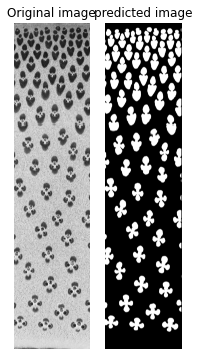

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage.io as io
from skimage import img_as_ubyte
from skimage.transform import rotate, rescale, resize
import re
from common.data_prep import set_dir

%matplotlib inline

# define your job number under _run directory
job_num = '001'
# set reduction_factor of the initial image 
r_f = 2
# target image for segmentation
target = './_test'
r_target = os.path.join('./_run',job_num,'segmentation')

set_dir(os.path.join('./_run',job_num,'extracted_VB_images')) # extracted VBs along the radial positions

l1 = [filename for filename in os.listdir(target) if not filename.startswith('.')]
l2 = [filename for filename in os.listdir(r_target) if not filename.startswith('.')]
file_list1=sorted(l1, key=lambda s: int(re.search(r'\d+', s).group()))
file_list2=sorted(l2, key=lambda s: int(re.search(r'\d+', s).group()))

# number of the target image ###############
fln=15

img_path=os.path.join(target, file_list1[fln])
res_path=os.path.join(r_target, file_list2[fln])

img=io.imread(img_path, as_gray=True) # gray scaleでの読み込み
res=io.imread(res_path, as_gray=True) # gray scaleでの読み込み
res=rescale(res, 2, anti_aliasing=True)

# image rotation and take longer side as x-axis

img_rot=img
res_rot=res
# img_rot=rotate(img, 90, resize=True)
# res_rot=rotate(res, 90, resize=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3,6))
axes[0].imshow(img_rot, cmap='gray')
axes[0].set_title("Original image")
axes[1].imshow(res_rot, cmap='gray')
axes[1].set_title("predicted image")
axes[0].set_axis_off()
axes[1].set_axis_off()
fig.savefig('prediction.jpg')

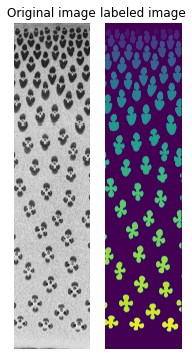

In [2]:
# skimageを利用して　大津法による二値化、morphology, measure.labelによる維管束抽出
from skimage import data, filters, measure, morphology

# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(res_rot)
mask = res_rot > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask,connectivity=2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3,6))
axes[0].imshow(img_rot, cmap='gray')
axes[0].set_title("Original image")
axes[0].set_axis_off()
axes[1].imshow(labels)
axes[1].set_title("labeled image")
axes[1].set_axis_off()
fig.savefig('labeled.jpg')

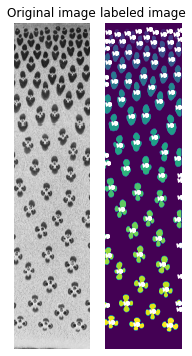

In [3]:
# morphological parameters 
properties = ['label','centroid', 'area', 'eccentricity', 'perimeter','extent', 'convex_area']
props = measure.regionprops_table(labels, res_rot, properties = properties)

import pandas as pd  
data = pd.DataFrame(props)  
data.head()  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3,6))
axes[0].imshow(img_rot, cmap='gray')
axes[0].set_title("Original image")
axes[1].imshow(labels)
axes[1].scatter(data['centroid-1'],data['centroid-0'], color='white', marker="$VB$")
axes[1].set_title("labeled image")
axes[0].set_axis_off()
axes[1].set_axis_off()
fig.savefig('labeledwithnum.jpg')

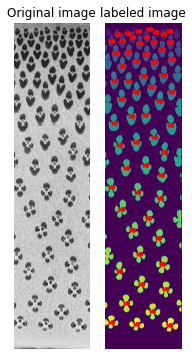

In [4]:
# remove items with centroid as near as 100 pixcel to upper or lower border
df=data[data['centroid-1'] >=100]
df=df[df['centroid-1'] <=(df['centroid-1'].max()-100)]

# remove items with area less than 500 and more than 100000
df=df[df['area']>=500]
df=df[df['area']<=100000]

#　record relative position in radial diirection
df['centroid-0_relative']=df['centroid-0']/df['centroid-0'].max()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3,6))
axes[0].imshow(img_rot, cmap='gray')
axes[0].set_title("Original image")
axes[1].imshow(labels)
axes[1].scatter(df['centroid-1'],df['centroid-0'], color='red', marker="$VB$")
axes[1].set_title("labeled image")
axes[0].set_axis_off()
axes[1].set_axis_off()
fig.savefig('labeledwithnum_after_edit.jpg')

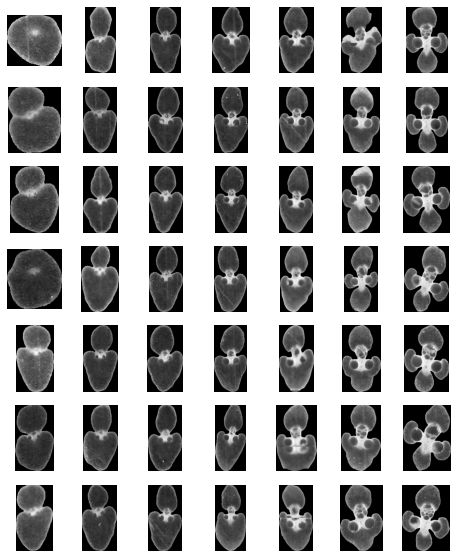

In [5]:
from skimage import data, filters, measure, morphology

# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(res_rot)
mask = res_rot > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask,connectivity=2)

# example display of extracted VBs
num=int(np.sqrt(len(list(df['label']))))
exVB=os.path.join('./_run',job_num,'extracted_VB_images')
fig, axes = plt.subplots(ncols=num,nrows=num, figsize=(8,10))
for i ,lbl in enumerate(list(df['label'])):
    if i < num*num :       
        p,q = divmod(i,num)                    
        x,y=np.where(labels==lbl)
        dx=x.max()-x.min() #df['centroid-1'][i]
        dy=y.max()-y.min() #df['centroid-0'][i]
        #   print(df['centroid-1'][i],df['centroid-0'][i])
        im = np.zeros((dx+1,dy+1))
        im[x-x.min(),y-y.min()] = img_rot[x,y]
        axes[q,p].imshow(im, cmap='gray')
        axes[q,p].axis('off')
    #print(lbl)
    #print("{:.8}".format(df['centroid-0_relative'][lbl-1])+'_sp'+str(fln)+'.png')
    img=img_as_ubyte(im)
    io.imsave(exVB+"/{:.6f}".format(df['centroid-0_relative'][lbl-1])+'_sp'+str(fln)+'.png', img)

plt.show()


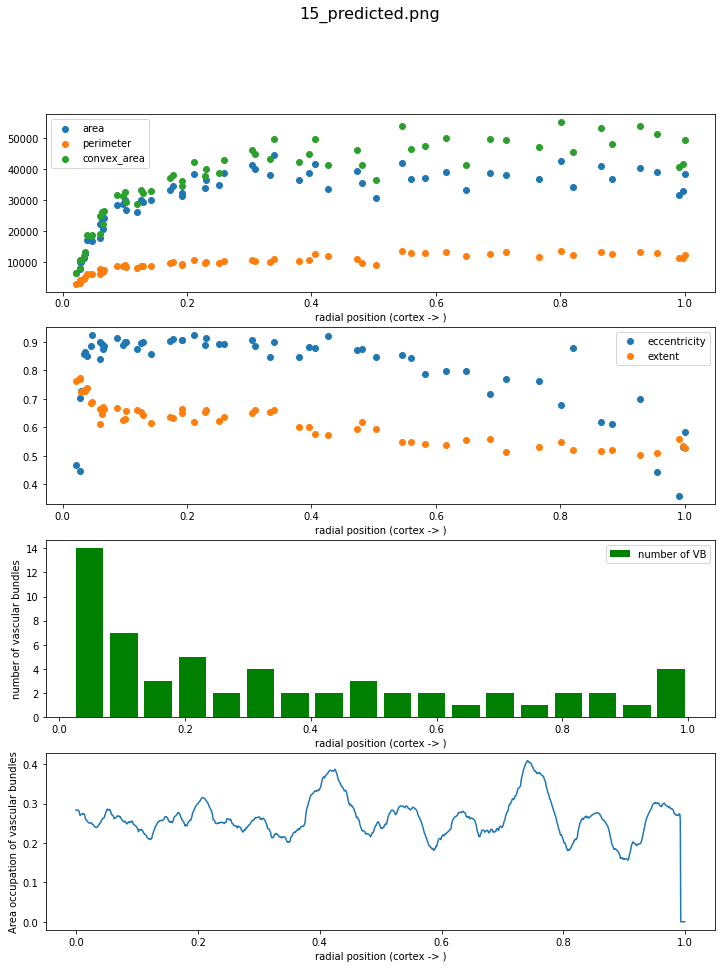

In [7]:
#binarize
label_flt=labels
label_flt[label_flt >=1]=1

# plotting morphological parameter along radial position
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,15))

fig.suptitle(file_list2[fln], fontsize=16)

axes[0].scatter(df['centroid-0_relative'],df['area'],label= 'area')
axes[0].scatter(df['centroid-0_relative'],df['perimeter']*10,label= 'perimeter')
axes[0].scatter(df['centroid-0_relative'],df['convex_area'],label= 'convex_area')
axes[0].set_xlabel('radial position (cortex -> )')
axes[0].legend()


axes[1].scatter(df['centroid-0_relative'],df['eccentricity'], label= 'eccentricity')
axes[1].scatter(df['centroid-0_relative'],df['extent'], label='extent')
axes[1].set_xlabel('radial position (cortex -> )')
axes[1].legend()


axes[2].hist(df['centroid-0_relative'],bins=18,color='green',rwidth=0.8, label='number of VB')
axes[2].set_xlabel('radial position (cortex -> )')
axes[2].set_ylabel('number of vascular bundles')
axes[2].legend()

a1=list(range(label_flt.shape[1]))
a2=np.array(a1)/label_flt.shape[1]
axes[3].plot(a2,label_flt.sum(axis=0)/label_flt.shape[0])
axes[3].set_xlabel('radial position (cortex -> )')
axes[3].set_ylabel('Area occupation of vascular bundles')

plt.show()

fig.savefig(os.path.join('./_run',job_num,'morphology', 'morph_'+file_list2[fln]), dpi=300)

The end of codes